**Loading in 3 data sources:**
- Clean tap water
- Wastewater
- Treated water

In [266]:
#loading data into the data frame
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
import openpyxl
from scipy.signal import find_peaks
import plotly.graph_objects as go
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import cross_val_score, KFold
from sklearn.pipeline import Pipeline


**Cleaning the data:**
- Triplicate measurements of eachs sample were taken, the average needs to be computed to yield a robust spectral footprint
- In addition, these samples all have different alpha numeric designations, the excel file needs to be cleaned and all of the samples grouped

In [267]:
# Loading data sheets according to sample type
treated_waves= pd.read_excel("Sample no Filter.xlsx", sheet_name="Samples", header=None)
clean_waves= pd.read_excel("Sample no Filter.xlsx", sheet_name="Clean Water", header=None)
bw_waves= pd.read_excel("Sample no Filter.xlsx", sheet_name="Blackwater", header=None)

#grouping triplicate measurements and taking the average, then replacing the triplicate measurements with the average in the
#data frame

##blackwater
# Assume first column = sample names, rest = numeric data
bw_waves.columns = ["Sample"] + [f"Col{i}" for i in range(1, bw_waves.shape[1])]
# Extract group prefix (BW1, BW2, BW3...)
bw_waves["Group"] = bw_waves["Sample"].str.extract(r'^(BW\d+)')
# Compute averages across all numeric columns per group
bw_waves = bw_waves.groupby("Group").mean(numeric_only=True).reset_index()


##treated_water
treated_waves = treated_waves.iloc[1:].reset_index(drop=True)

# Rename columns: first col = Sample, rest = numeric data
treated_waves.columns = ["Sample"] + [f"Col{i}" for i in range(1, treated_waves.shape[1])]

# Extract group prefix: everything before the first dash
treated_waves["Group"] = treated_waves["Sample"].astype(str).str.extract(r'^([A-Za-z0-9]+)')

# Compute averages across all numeric columns per group
treated_waves = treated_waves.groupby("Group").mean(numeric_only=True).reset_index()


##clean_water
clean_waves = clean_waves.iloc[1:].reset_index(drop=True)

# Rename columns: first col = Sample, rest = numeric data
clean_waves.columns = ["Sample"] + [f"Col{i}" for i in range(1, clean_waves.shape[1])]

# Extract group prefix: everything before the first dash
clean_waves["Group"] = clean_waves["Sample"].astype(str).str.extract(r'^([A-Za-z0-9]+)')

# Compute averages across all numeric columns per group
clean_waves = clean_waves.groupby("Group").mean(numeric_only=True).reset_index()

#merging related data
tw_bw_clean_waves = pd.concat([treated_waves, bw_waves, clean_waves])

**Importing Physiochemical Measurements and Displaying Descriptive Statistics**

In [268]:
#importing turbidity measurements 
turb = pd.read_excel('physiochemical data.xlsx', sheet_name='Master Physiochem', usecols=['Turbidity (NTU)'])
#checking that data was correctly imported

#importing total suspended solids measurements 
tss = pd.read_excel('physiochemical data.xlsx', sheet_name='TSS', usecols=['TSS (% w/v)'])

#importing total solids measurements 
ts = pd.read_excel('physiochemical data.xlsx', sheet_name='TS', usecols=['%TS (w/w)'])

**Missing physiochemical data analysis**

<Axes: >

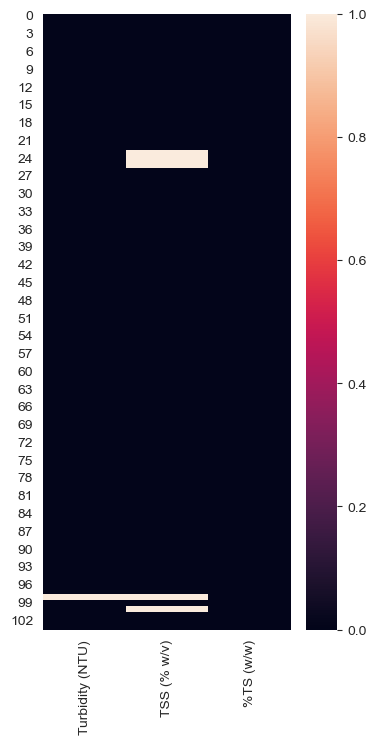

In [269]:
#IDA 6. handling missing values
merged_turbtssts = pd.concat([turb, tss,ts], axis=1)
plt.figure(figsize=(4,8))
# sns.heatmap(df.isna().transpose(), cmap="plasma")
# sns.heatmap(df.isna(), cmap="viridis")
sns.heatmap(merged_turbtssts.isna(), cmap="rocket")

**KNN: imputation of TSS and Turbidity Parameters**

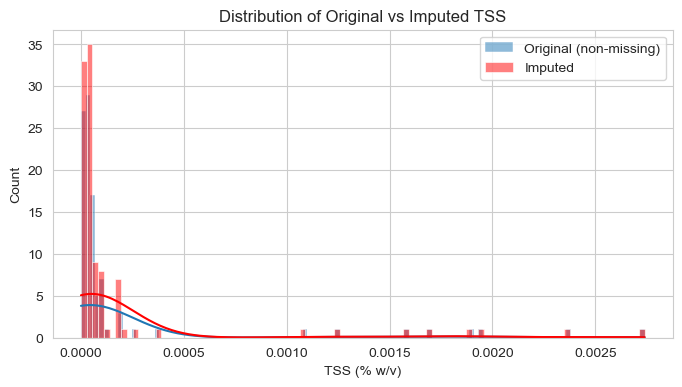

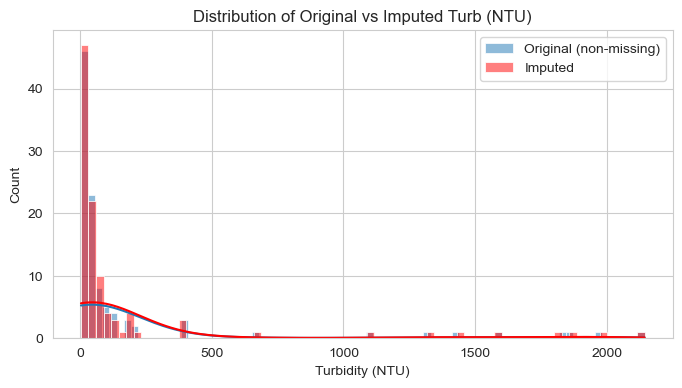

In [270]:
#From Week06 In class assignment CMSE830- KNN nearest neighbors
#missing and not missing
tss_missing = tss[tss.isnull().any(axis=1)]
tss_not_missing = tss.dropna()

#preparing scalar for KNN
scaler = StandardScaler()
tss_scaled = pd.DataFrame(scaler.fit_transform(tss_not_missing), columns = tss_not_missing.columns)

#intialize and fit KNN imputer
imputer = KNNImputer(n_neighbors=5, weights ='distance')
#here we have to make the scatter plot of the data without missing values so they aren't skewed by missing values, then we overlay the missing values 
#on the scatter plot 
#what does .fit do? Training on non-missing data ---it's machine learning and has never seen this data set before, so it has to train
imputer.fit(tss_scaled)

# function to impute and inverse transform the data
def impute_and_inverse_transform(data):
    # Ensure 'data' is always a DataFrame with proper column names
    scaled_data = pd.DataFrame(scaler.transform(data), columns=data.columns, index=data.index)
    imputed_scaled = imputer.transform(scaled_data)
    return pd.DataFrame(scaler.inverse_transform(imputed_scaled), columns=data.columns, index=data.index)

# impute missing values
tss_imputed = impute_and_inverse_transform(tss)

# compare original and imputed data for tss
fig = plt.figure(figsize=(8, 4))
sns.histplot(tss_not_missing.dropna(), kde=True, color='blue', alpha=0.5, label='Original (non-missing)')
#sns.histplot(tss_imputed.loc[tss['TSS (% w/v)'].isnull(), 'TSS (% w/v)'], kde=True, color='red', alpha=0.5, label='Imputed')
sns.histplot(tss_imputed['TSS (% w/v)'], kde=True, color='red', alpha=0.5, label='Imputed')
plt.title('Distribution of Original vs Imputed TSS')
plt.legend()
plt.show()

#From Week06 In class assignment CMSE830
#missing and not missing
turb_missing = turb[turb.isnull().any(axis=1)]
turb_not_missing = turb.dropna()

#preparing scalar for KNN
scaler = StandardScaler()
turb_scaled = pd.DataFrame(scaler.fit_transform(turb_not_missing), columns = turb_not_missing.columns)

#intialize and fit KNN imputer
#imputer = KNNImputer(n_neighbors=5)
#modded above function to include 10 neighbors and weight the imputed value depending on how close the points were-the closer the point the more it 
#affects the imputing value
imputer = KNNImputer(n_neighbors=3, weights ='distance')
#here we have to make the scatter plot of the data without missing values so they aren't skewed by missing values, then we overlay the missing values 
#on the scatter plot 
#what does .fit do? Training on non-missing data ---it's machine learning and has never seen this data set before, so it has to train
imputer.fit(turb_scaled)

# function to impute and inverse transform the data
def impute_and_inverse_transform(data):
    # Ensure 'data' is always a DataFrame with proper column names
    scaled_data = pd.DataFrame(scaler.transform(data), columns=data.columns, index=data.index)
    imputed_scaled = imputer.transform(scaled_data)
    return pd.DataFrame(scaler.inverse_transform(imputed_scaled), columns=data.columns, index=data.index)

# impute missing values
turb_imputed = impute_and_inverse_transform(turb)

# compare original and imputed data for tss
fig = plt.figure(figsize=(8, 4))
sns.histplot(turb_not_missing.dropna(), kde=True, color='blue', alpha=0.5, label='Original (non-missing)')
sns.histplot(turb_imputed['Turbidity (NTU)'], kde=True, color='red', alpha=0.5, label='Imputed')
plt.title('Distribution of Original vs Imputed Turb (NTU)')
plt.legend()
plt.show()


**IDA 2:Data Cleaning and Pre-processing**
- All measured parameters (TSS, Turbidity, and TS) need to be split between treated water and blackwater

In [271]:
#tss and turb data was imputed, no data missing for ts

tw_tss = tss_imputed[0:96]
tw_ts = ts[0:96]
tw_turb = turb_imputed[0:96]

bw_tss = tss_imputed[96:106]
bw_ts = ts[96:106]
bw_turb = turb_imputed[96:106]

#reading sample names
sample_IDs = pd.read_excel('physiochemical data.xlsx', sheet_name='Master Physiochem', usecols=['Sample'])

#merging related data
tw_physio = pd.concat([tw_tss, tw_ts,tw_turb], axis=1)
bw_physio = pd.concat([bw_tss, bw_ts,bw_turb], axis=1)
tw_bw_physio = pd.concat([ tw_physio,bw_physio])

# Add the Sample IDs as a new column
tw_bw_physio.insert(0, 'Sample', sample_IDs['Sample'].values)

print(tw_bw_physio.head())
print(clean_waves['Group'])

  Sample  TSS (% w/v)  %TS (w/w)  Turbidity (NTU)
0     A1     0.000035   0.001539             18.5
1     B1     0.000031   0.001415             18.1
2     C1     0.000087   0.001635             52.5
3     D1     0.000045   0.001656             29.8
4     E1     0.000094   0.001124             85.3
0    Blank1
1    Blank2
2    Blank3
3    Blank4
4    Blank5
5    Blank6
6    Blank7
Name: Group, dtype: object


**Adding clean water physiochemical results**

In [272]:
# Define column names (excluding 'Sample')
value_cols = [col for col in tw_bw_physio.columns if col != 'Sample']

# Generate random values with different ranges
col1 = np.random.uniform(0, 0.00002, size=(7,))   # TSS (% w/v)
col2 = np.random.uniform(0, 0.00002, size=(7,))   # %TS (w/w)
col3 = np.random.uniform(0, 0.02, size=(7,))     # Turbidity (NTU)

# Stack into DataFrame
new_df = pd.DataFrame(
    np.column_stack([col1, col2, col3]),
    columns=value_cols
)

# Add the Sample IDs as the first column
new_df = pd.concat(
    [clean_waves[['Group']].rename(columns={'Group':'Sample'}).head(7), new_df],
    axis=1
)

# Append to the original DataFrame
tw_bw_clean_physio = pd.concat([tw_bw_physio, new_df], ignore_index=True)

print(tw_bw_clean_physio.tail(10))

     Sample  TSS (% w/v)  %TS (w/w)  Turbidity (NTU)
101     BW6     0.001900   0.003198      1872.000000
102     BW7     0.002360   0.003454      1321.600000
103     BW8     0.002740   0.003447      1824.000000
104  Blank1     0.000005   0.000010         0.002026
105  Blank2     0.000016   0.000013         0.001939
106  Blank3     0.000010   0.000007         0.012093
107  Blank4     0.000004   0.000014         0.001249
108  Blank5     0.000004   0.000017         0.015174
109  Blank6     0.000011   0.000009         0.002681
110  Blank7     0.000008   0.000019         0.002438


**tw_bw_clean_physio**  is data frame with all physiochemical data

**Plotting and visualizing Physiochem**

**Descriptive statistics of physiochemical parameters**

Return value = **stats**

In [273]:
# Assume your DataFrame is called df with columns:
# ['Sample', 'TSS (% w/v)', '%TS (w/w)', 'Turbidity (NTU)']

# Segregating samples according to sample name [treated water (A1, B2, etc), clean (Blank1, Blank2), blackwater feed (BW1, BW2) etc)
def classify_sample(sample):
    if sample.startswith("Blank"):
        return "Clean Water"
    elif sample.startswith("BW"):
        return "Contaminated Water"
    else:
        return "Treated Water"

# Use classify sample
tw_bw_clean_physio['Type'] = tw_bw_clean_physio['Sample'].apply(classify_sample)

# Describe statistics in a separate value
stats = tw_bw_clean_physio.groupby('Type').describe()

**Plotting means vs sample type**

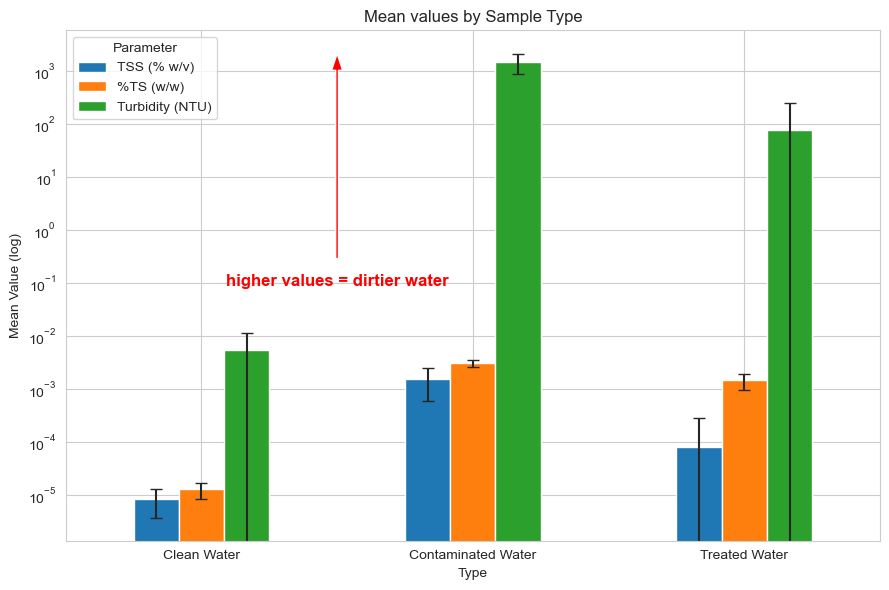

In [274]:

grouped_stats = tw_bw_clean_physio.groupby('Type')[['TSS (% w/v)', '%TS (w/w)', 'Turbidity (NTU)']].agg(['mean','std'])

# Extract mean and std separately for plotting
means = grouped_stats.xs('mean', axis=1, level=1)
stds  = grouped_stats.xs('std', axis=1, level=1)

# --- Step 3: Plot with error bars and custom colors ---
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # blue, orange, green
ax = means.plot(kind='bar', yerr=stds, figsize=(9,6), capsize=4, color=colors)

plt.title("Mean values by Sample Type")
plt.yscale('log')
plt.ylabel("Mean Value (log)")
plt.xticks(rotation=0)
plt.legend(title="Parameter")

# Arrow formating
# Find x positions of Clean Water and Dirty Water groups
clean_index = list(means.index).index("Clean Water")
dirty_index = list(means.index).index("Contaminated Water")

# Midpoint between Clean and Dirty (x-axis)
clean_index = list(means.index).index("Clean Water")
dirty_index = list(means.index).index("Contaminated Water")
mid_x = (clean_index + dirty_index) / 2

# Midpoint of y-axis on log scale
ymin, ymax = plt.ylim()
y_mid = (ymin * ymax) ** 0.5   # geometric mean for log scale

# Place arrow tail at midpoint, head near title
plt.annotate(
    "higher values = dirtier water",
    xy=(mid_x, ymax * 0.60),              # arrow head near title/top
    xytext=(mid_x, y_mid),                # arrow tail at vertical midpoint
    arrowprops=dict(facecolor='red', shrink=0.05, width=2, headwidth=8),
    ha='center',
    color='red',
    fontsize=12,
    fontweight='bold'
)

plt.tight_layout()
plt.show()


**Plotting wavelengths according to sample type**

In [275]:
#tw_bw_clean_waves['Type'] = tw_bw_clean_waves['Sample'].apply(classify_sample)
wavelengths = pd.read_excel("Sample no Filter.xlsx", sheet_name="Samples", nrows=1, header = None)
wavelengths = wavelengths.drop(columns=[0])

**Plotting Spectral Fingerprints**

C:\Users\olive\AppData\Local\Temp\ipykernel_29044\58453255.py:20: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



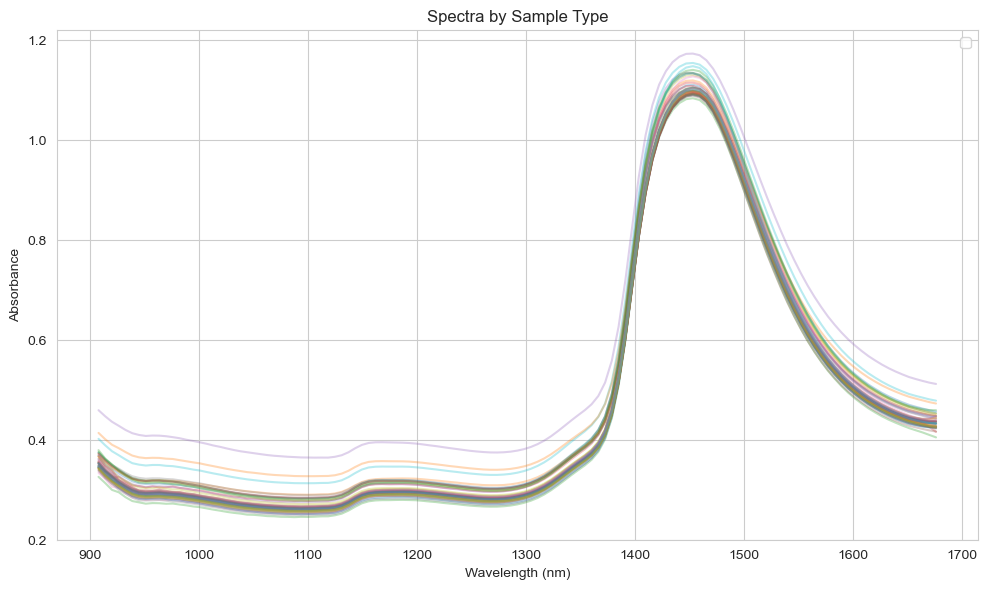

In [276]:
tw_bw_clean_waves['Type'] = tw_bw_clean_waves['Group'].apply(classify_sample)

# --- Step 2: Extract wavelength values ---
wavelengths_values = wavelengths.values.flatten()  # drop first col if needed

# --- Step 3: Plot spectra by sample type ---
plt.figure(figsize=(10,6))

for sample_type, group in tw_bw_clean_waves.groupby('Type'):
    # Drop Sample + Type columns to get numeric values
    numeric_data = group.drop(columns=['Group','Type']).values
    
    # Plot each sample in the group
    for row in numeric_data:
        plt.plot(wavelengths_values, row, alpha=0.3, label=sample_type if row is numeric_data[0] else "")

plt.title("Spectra by Sample Type")
plt.xlabel("Wavelength (nm)")
plt.ylabel("Absorbance")
plt.legend()
plt.tight_layout()
plt.show()


**Visualizing the fingerprints based on sample type**

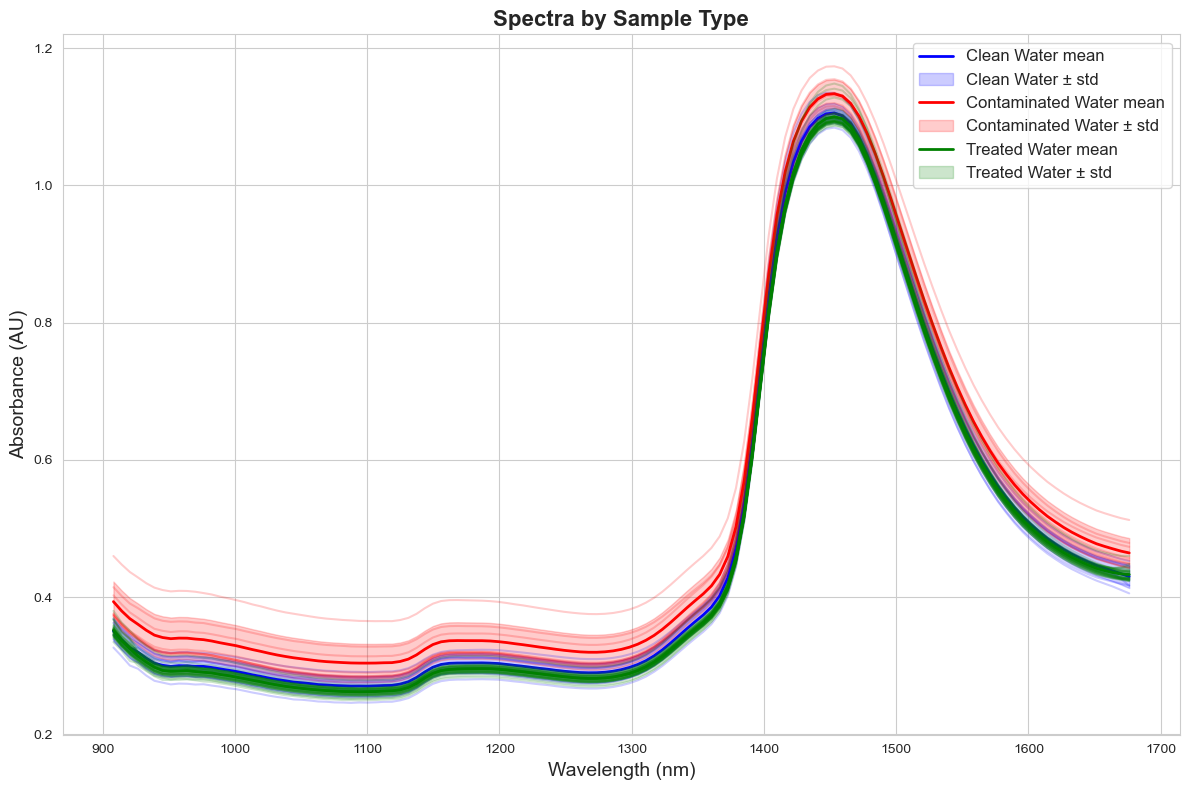

In [278]:
# --- Step 2: Extract wavelength values ---
wavelengths_values = wavelengths.values.flatten()

# --- Step 3: Define colors for each type ---
colors = {
    "Clean Water": "blue",
    "Contaminated Water": "red",
    "Treated Water": "green"
}

plt.figure(figsize=(12,8))
sns.set_style("whitegrid")

# --- Step 4: Plot spectra ---
for sample_type, group in tw_bw_clean_waves.groupby('Type'):
    data = group.drop(columns=['Group','Type']).values
    
    # Plot all individual spectra with transparency
    for row in data:
        plt.plot(wavelengths_values, row, color=colors[sample_type], alpha=0.2)
    
    # Compute mean and std
    mean = data.mean(axis=0)
    std  = data.std(axis=0)
    
# Plot mean spectrum
    plt.plot(wavelengths_values, mean, color=colors[sample_type], linewidth=2,
             label=f"{sample_type} mean")
    
    # Shaded error band
    plt.fill_between(wavelengths_values, mean-std, mean+std,
                     color=colors[sample_type], alpha=0.2,
                     label=f"{sample_type} ± std")

# --- Step 5: Formatting ---
plt.title("Spectra by Sample Type", fontsize=16, fontweight='bold')
plt.xlabel("Wavelength (nm)", fontsize=14)
plt.ylabel("Absorbance (AU)", fontsize=14)
plt.legend(fontsize=12, loc="upper right")
plt.tight_layout()
plt.show()


**Separate water types and plot separately**

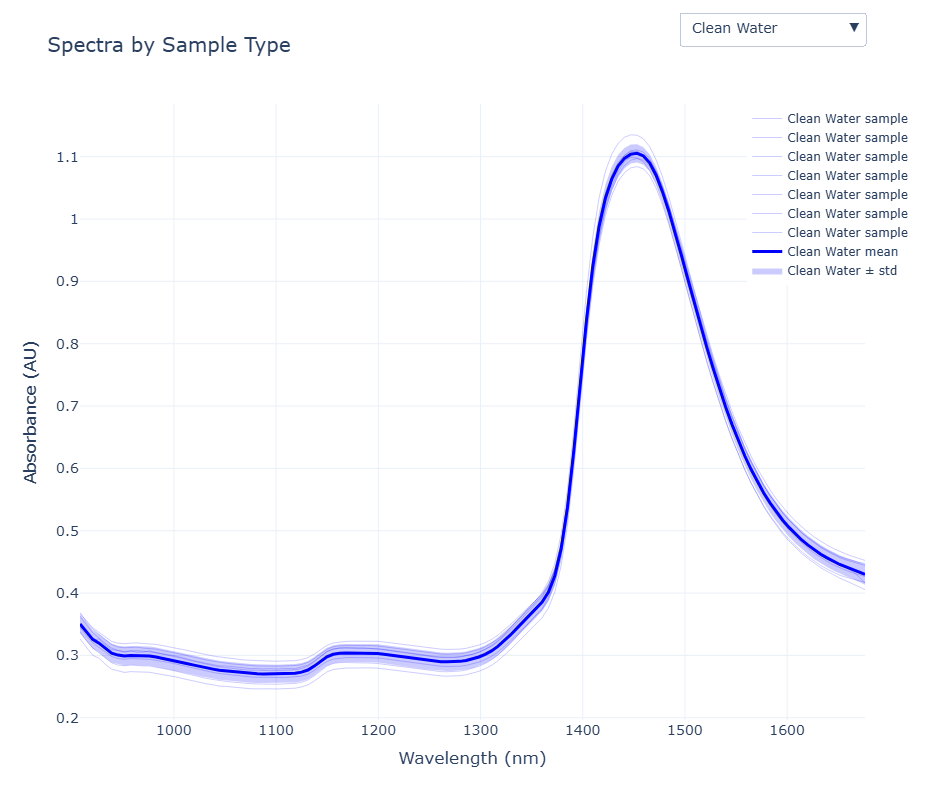

In [279]:
# --- Step 2: Build traces for each sample type ---
traces = []
trace_groups = {}

for sample_type, group in tw_bw_clean_waves.groupby('Type'):
    data = group.drop(columns=['Group','Type']).values
    mean = data.mean(axis=0)
    std  = data.std(axis=0)

    trace_groups[sample_type] = []

    # Individual spectra
    for row in data:
        idx = len(traces)
        traces.append(go.Scatter(
            x=wavelengths_values,
            y=row,
            mode='lines',
            line=dict(color=colors[sample_type], width=1),
            opacity=0.2,
            visible=(sample_type=="Clean Water"),  # default visible
            name=f"{sample_type} sample"
        ))
        trace_groups[sample_type].append(idx)
# Mean spectrum
    idx = len(traces)
    traces.append(go.Scatter(
        x=wavelengths_values,
        y=mean,
        mode='lines',
        line=dict(color=colors[sample_type], width=3),
        visible=(sample_type=="Clean Water"),
        name=f"{sample_type} mean"
    ))
    trace_groups[sample_type].append(idx)

    # Error band
    idx = len(traces)
    traces.append(go.Scatter(
        x=wavelengths_values.tolist()+wavelengths_values[::-1].tolist(),
        y=(mean+std).tolist()+(mean-std)[::-1].tolist(),
        fill='toself',
        fillcolor=colors[sample_type],
        opacity=0.2,
        line=dict(color='rgba(255,255,255,0)'),
        visible=(sample_type=="Clean Water"),
        name=f"{sample_type} ± std"
    ))
    trace_groups[sample_type].append(idx)

# --- Step 3: Dropdown buttons ---
buttons = []
for sample_type in trace_groups:
    visible_mask = [False] * len(traces)
    for idx in trace_groups[sample_type]:
        visible_mask[idx] = True
    buttons.append(dict(
        label=sample_type,
        method="update",
        args=[{"visible": visible_mask},
              {"title": f"{sample_type} Spectra"}]
    ))

# --- Step 4: Build figure ---
fig = go.Figure(data=traces)
fig.update_layout(
    title="Spectra by Sample Type",
    xaxis_title="Wavelength (nm)",
    yaxis_title="Absorbance (AU)",
    template="plotly_white",
    font=dict(size=14),
    height=800,   # taller plot
    updatemenus=[dict(
        active=0,
        buttons=buttons,
        x=1, y=1.15,          # position at top right
        xanchor="right", 
        yanchor="top"
    )],
    legend=dict(font=dict(size=12), x=0.85, y=1)
)


fig.show()

**Finding common peaks and valleys**

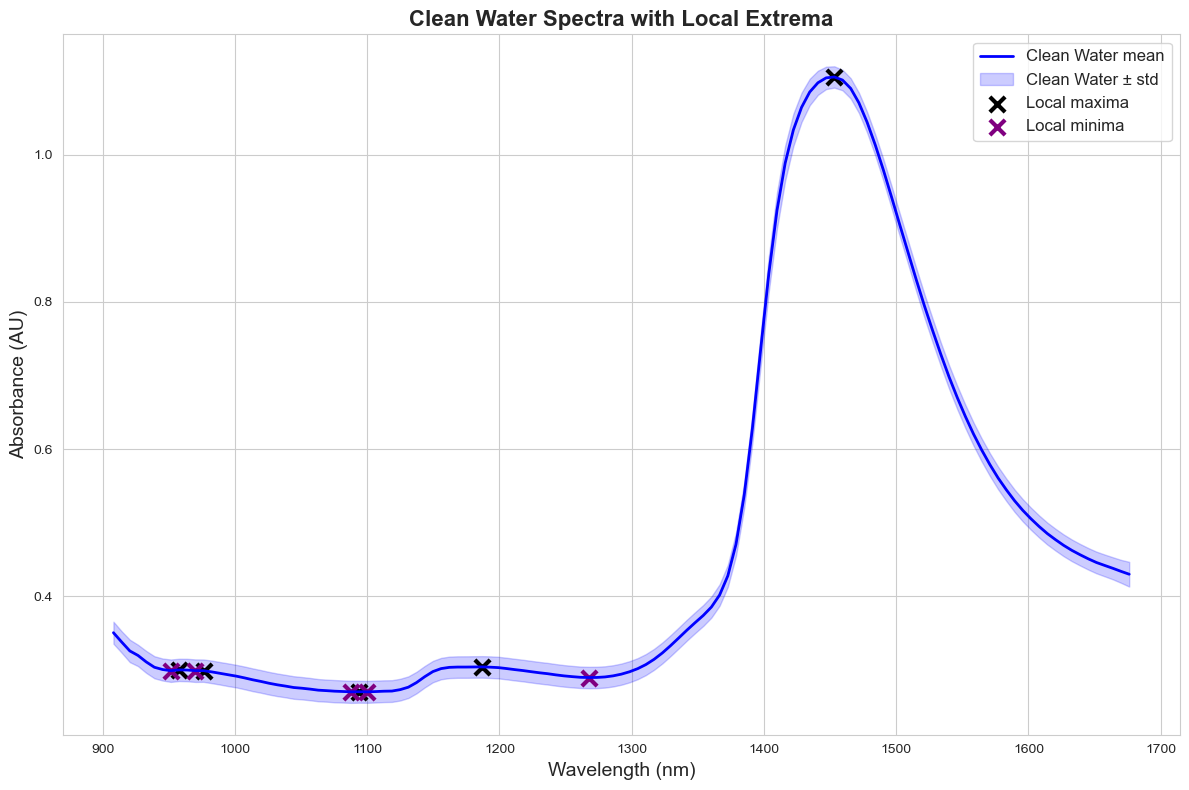

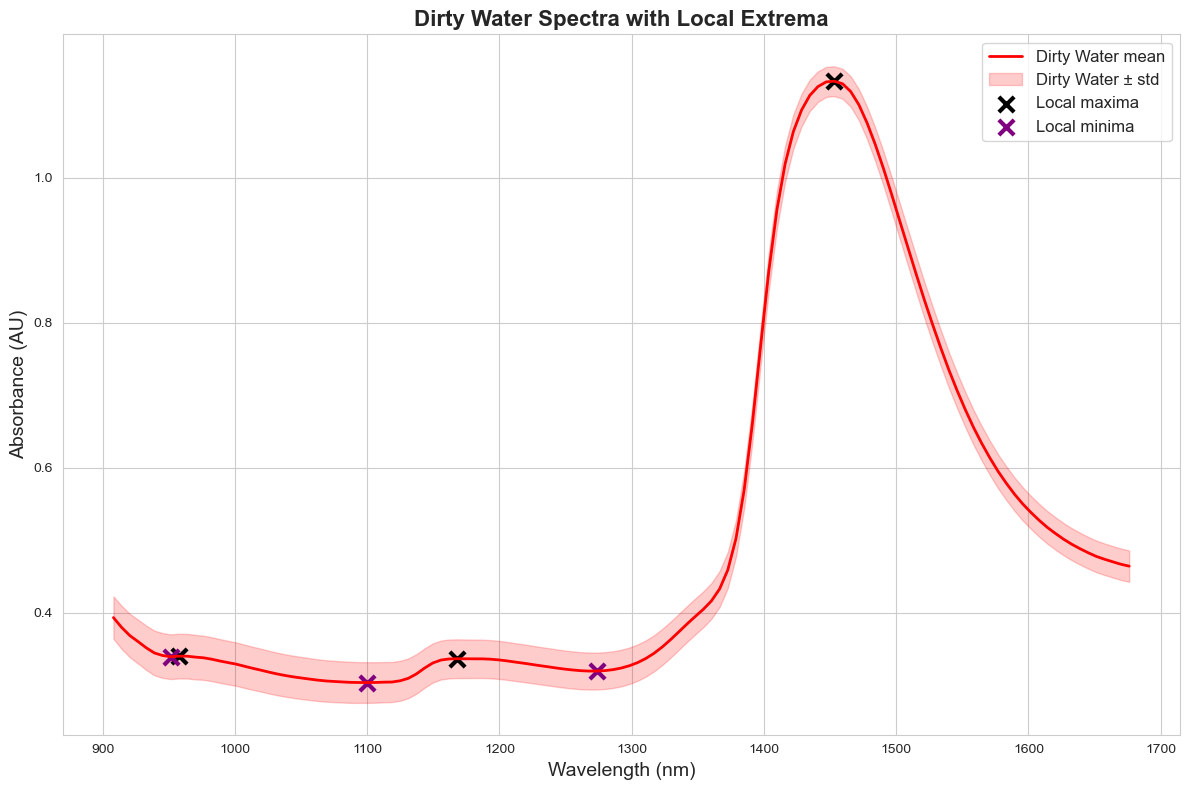

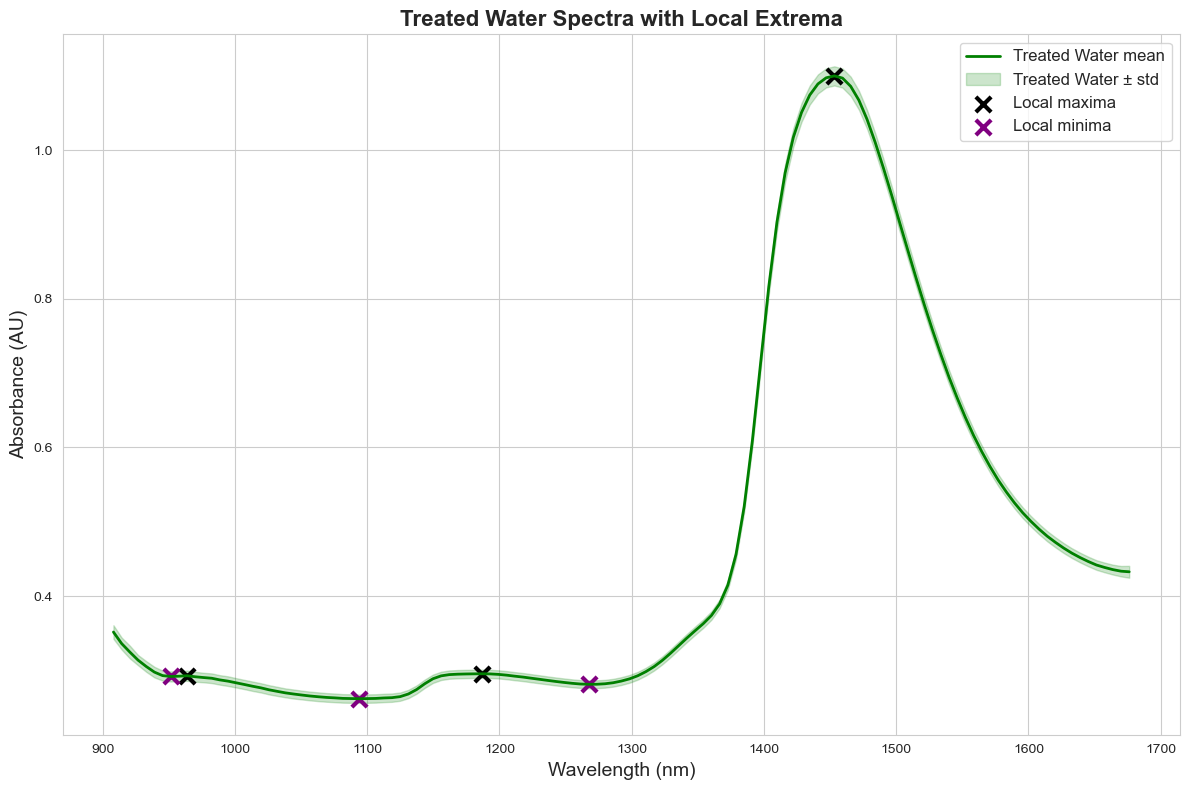

In [249]:
# Loop through each sample type
for sample_type, group in tw_bw_clean_waves.groupby('Type'):
    plt.figure(figsize=(12,8))
    
    # Extract numeric data
    data = group.drop(columns=['Group','Type']).values
    
    # Compute mean and std
    mean = data.mean(axis=0)
    std  = data.std(axis=0)
    
    # Plot mean spectrum
    plt.plot(wavelengths_values, mean, color=colors[sample_type], linewidth=2,
             label=f"{sample_type} mean")
    
    # Shaded error band
    plt.fill_between(wavelengths_values, mean-std, mean+std,
                     color=colors[sample_type], alpha=0.2,
                     label=f"{sample_type} ± std")
    
    # --- Find local maxima and minima ---
    maxima_idx, _ = find_peaks(mean)
    minima_idx, _ = find_peaks(-mean)
    
    # Plot maxima (black X) and minima (purple X)
    plt.scatter(wavelengths_values[maxima_idx], mean[maxima_idx],
                marker='x', s=120, color='black', linewidths=3,
                label="Local maxima")
    plt.scatter(wavelengths_values[minima_idx], mean[minima_idx],
                marker='x', s=120, color='purple', linewidths=3,
                label="Local minima")
    
    # Formatting
    plt.title(f"{sample_type} Spectra with Local Extrema", fontsize=16, fontweight='bold')
    plt.xlabel("Wavelength (nm)", fontsize=14)
    plt.ylabel("Absorbance (AU)", fontsize=14)
    plt.legend(fontsize=12, loc="upper right")
    plt.tight_layout()
    plt.show()


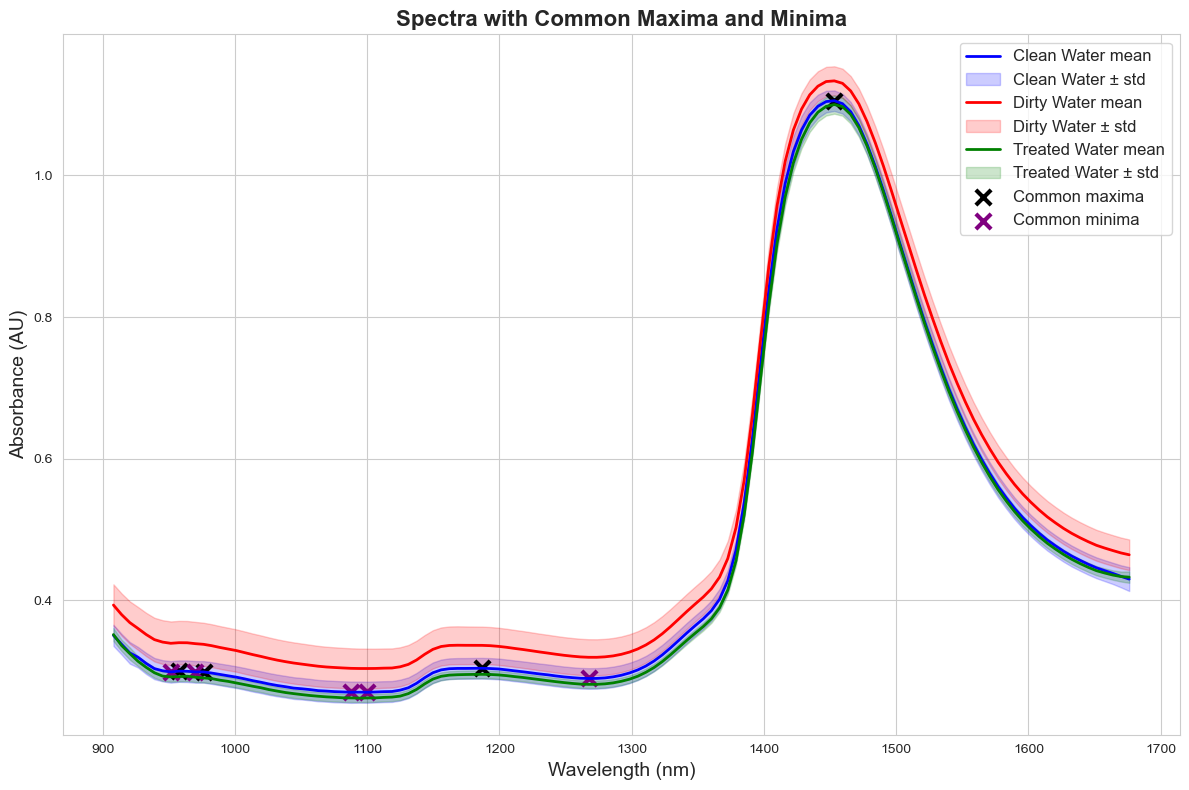

In [250]:
# --- Step 1: Compute mean and std for each type ---
mean_spectra = {}
std_spectra = {}
for sample_type, group in tw_bw_clean_waves.groupby('Type'):
    data = group.drop(columns=['Group','Type']).values
    mean_spectra[sample_type] = data.mean(axis=0)
    std_spectra[sample_type]  = data.std(axis=0)

# --- Step 2: Find maxima and minima indices for each mean spectrum ---
maxima_sets = []
minima_sets = []
for sample_type, mean in mean_spectra.items():
    maxima_idx, _ = find_peaks(mean)
    minima_idx, _ = find_peaks(-mean)
    maxima_sets.append(set(maxima_idx))
    minima_sets.append(set(minima_idx))

# --- Step 3: Define function to find common peaks within tolerance ---
def find_common_peaks(sets, tolerance=5):
    common = []
    # Use the first set as reference
    ref = sets[0]
    for idx in ref:
        if all(any(abs(idx - other) <= tolerance for other in s) for s in sets[1:]):
            common.append(idx)
    return np.array(common)

common_maxima = find_common_peaks(maxima_sets, tolerance=5)
common_minima = find_common_peaks(minima_sets, tolerance=5)

# --- Step 4: Plot all mean spectra together ---
plt.figure(figsize=(12,8))

for sample_type in mean_spectra:
    mean = mean_spectra[sample_type]
    std  = std_spectra[sample_type]
    
    # Mean spectrum
    plt.plot(wavelengths_values, mean, color=colors[sample_type], linewidth=2,
             label=f"{sample_type} mean")
    
    # Shaded error band
    plt.fill_between(wavelengths_values, mean-std, mean+std,
                     color=colors[sample_type], alpha=0.2,
                     label=f"{sample_type} ± std")
# --- Step 5: Overlay common maxima/minima ---
plt.scatter(wavelengths_values[list(common_maxima)],
            [mean_spectra[t][list(common_maxima)] for t in mean_spectra][0],
            marker='x', s=120, color='black', linewidths=3,
            label="Common maxima")

plt.scatter(wavelengths_values[list(common_minima)],
            [mean_spectra[t][list(common_minima)] for t in mean_spectra][0],
            marker='x', s=120, color='purple', linewidths=3,
            label="Common minima")

# --- Formatting ---
plt.title("Spectra with Common Maxima and Minima", fontsize=16, fontweight='bold')
plt.xlabel("Wavelength (nm)", fontsize=14)
plt.ylabel("Absorbance (AU)", fontsize=14)
plt.legend(fontsize=12, loc="upper right")
plt.tight_layout()
plt.show()


**Combining sample ID's with values at the common indexes into a new dataframe** 

In [251]:
# --- Step 1: Compute mean spectra and find maxima/minima indices ---
mean_spectra = {}
for sample_type, group in tw_bw_clean_waves.groupby('Type'):
    data = group.drop(columns=['Group','Type']).values
    mean_spectra[sample_type] = data.mean(axis=0)

# Find maxima/minima for each type
maxima_sets = []
minima_sets = []
for mean in mean_spectra.values():
    maxima_idx, _ = find_peaks(mean)
    minima_idx, _ = find_peaks(-mean)
    maxima_sets.append(maxima_idx)
    minima_sets.append(minima_idx)

# Function to find common peaks within tolerance
def find_common_peaks(sets, tolerance=5):
    common = []
    ref = sets[0]
    for idx in ref:
        if all(any(abs(idx - other) <= tolerance for other in s) for s in sets[1:]):
            common.append(idx)
    return np.array(common)
common_maxima = find_common_peaks(maxima_sets, tolerance=5)
common_minima = find_common_peaks(minima_sets, tolerance=5)

# --- Step 2: Extract wavelengths at these indices ---
selected_indices = np.sort(np.concatenate([common_maxima, common_minima]))
selected_wavelengths = wavelengths.iloc[0, selected_indices].values

# --- Step 3: Build new DataFrame ---
rows = []

# First row: wavelengths
header_row = ["Sample_ID"] + selected_wavelengths.tolist()
rows.append(header_row)

# Subsequent rows: sample ID + values at selected indices
for _, row in tw_bw_clean_waves.iterrows():
    sample_id = row['Group']
    values = row.drop(labels=['Group','Type']).values[selected_indices]
    rows.append([sample_id] + values.tolist())

# Convert to DataFrame
compeak_sum = pd.DataFrame(rows)

# --- Step 4: Optional formatting ---
compeak_sum.columns = ["Sample_ID"] + [f"Wavelength_{w}" for w in selected_wavelengths]

**Summary Statistics**

In [252]:
# Compute summary statistics for each sample type
summary_stats = []

for sample_type, group in tw_bw_clean_waves.groupby('Type'):
    data = group.drop(columns=['Group','Type']).values[:, selected_indices]
    
    stats = {
        "Sample_Type": sample_type,
        "N_samples": data.shape[0]
    }
    
    # For each wavelength, compute stats
    for i, wl in enumerate(selected_wavelengths):
        stats[f"{wl}_mean"]   = data[:, i].mean()
        stats[f"{wl}_std"]    = data[:, i].std()
        stats[f"{wl}_min"]    = data[:, i].min()
        stats[f"{wl}_max"]    = data[:, i].max()
        stats[f"{wl}_median"] = np.median(data[:, i])
    
    summary_stats.append(stats)

# --- Step 4: Convert to DataFrame ---
compeak_summary = pd.DataFrame(summary_stats)



**Concatinating common wavelength values with physiochemical parameters**

In [253]:
# Ensure both DataFrames have Sample_ID as the first column
if compeak_sum.columns[0] != "Sample_ID":
    compeak_sum = compeak_sum.rename(columns={compeak_sum.columns[0]: "Sample_ID"})
if tw_bw_clean_physio.columns[0] != "Sample_ID":
    tw_bw_clean_physio = tw_bw_clean_physio.rename(columns={tw_bw_clean_physio.columns[0]: "Sample_ID"})

# --- Step 1: Merge on Sample_ID ---
merged_df = pd.merge(
    tw_bw_clean_physio,
    compeak_sum,
    on="Sample_ID",
    how="inner"   # only keep matching IDs
)

# --- Step 2: Reorder columns so tw_bw_clean_physio comes first ---
ordered_cols = ["Sample_ID"] + \
               [col for col in tw_bw_clean_physio.columns if col != "Sample_ID"] + \
               [col for col in compeak_sum.columns if col != "Sample_ID"]

waves_physio = merged_df[ordered_cols]

**Performing a correlation matrix**

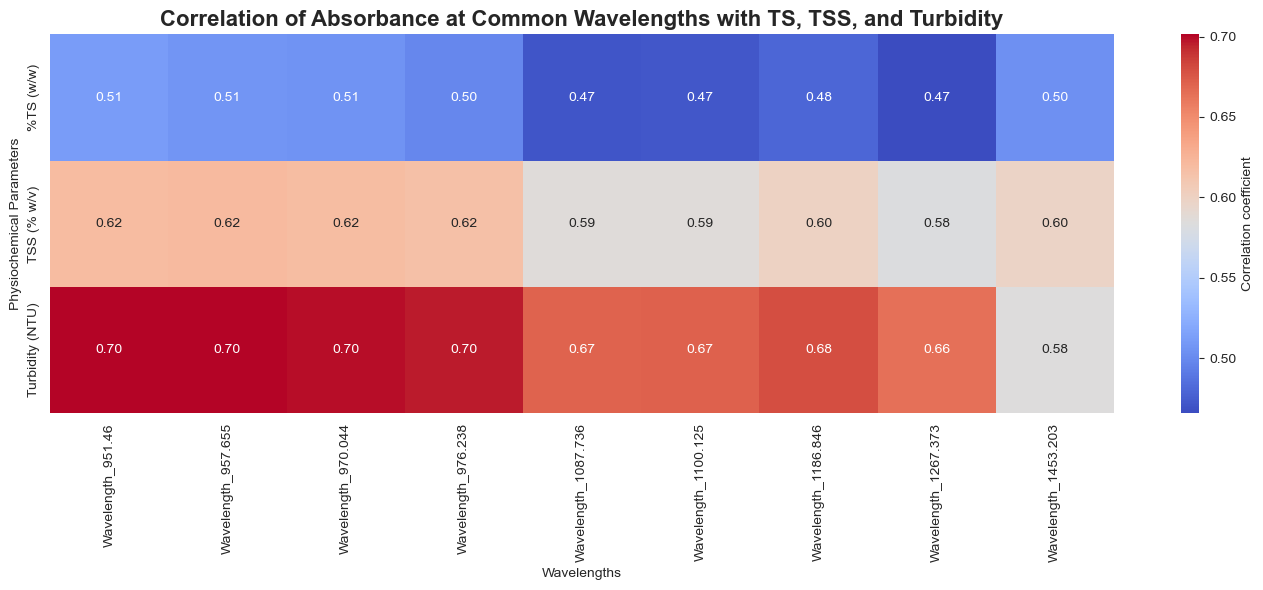

In [254]:
# --- Step 1: Ensure Sample_ID alignment ---
if compeak_sum.columns[0] != "Sample_ID":
    compeak_sum = compeak_sum.rename(columns={compeak_sum.columns[0]: "Sample_ID"})
if tw_bw_clean_physio.columns[0] != "Sample_ID":
    tw_bw_clean_physio = tw_bw_clean_physio.rename(columns={tw_bw_clean_physio.columns[0]: "Sample_ID"})

# --- Step 2: Merge absorbance + physiochemical data ---
# TSS (% w/v)     %TS (w/w)  Turbidity (NTU) 
merged_df = pd.merge(
    tw_bw_clean_physio[["Sample_ID","%TS (w/w)","TSS (% w/v)","Turbidity (NTU)"]],
    compeak_sum,
    on="Sample_ID",
    how="inner"
)

# --- Step 3: Compute correlation matrix ---
corr_matrix = merged_df.drop(columns=["Sample_ID"]).corr()

# --- Step 4: Extract correlations of TS, TSS, Turbidity vs wavelengths ---
physio_corr = corr_matrix.loc[["%TS (w/w)","TSS (% w/v)","Turbidity (NTU)"], compeak_sum.columns[1:]]

# --- Step 5: Plot heatmap ---
plt.figure(figsize=(14,6))
sns.heatmap(
    physio_corr,
    cmap="coolwarm",
    annot=True,
    fmt=".2f",
    cbar_kws={'label': 'Correlation coefficient'}
)
plt.title("Correlation of Absorbance at Common Wavelengths with TS, TSS, and Turbidity", fontsize=16, fontweight="bold")
plt.xlabel("Wavelengths")
plt.ylabel("Physiochemical Parameters")
plt.tight_layout()
plt.show()


**PCA Analysis on combined data**

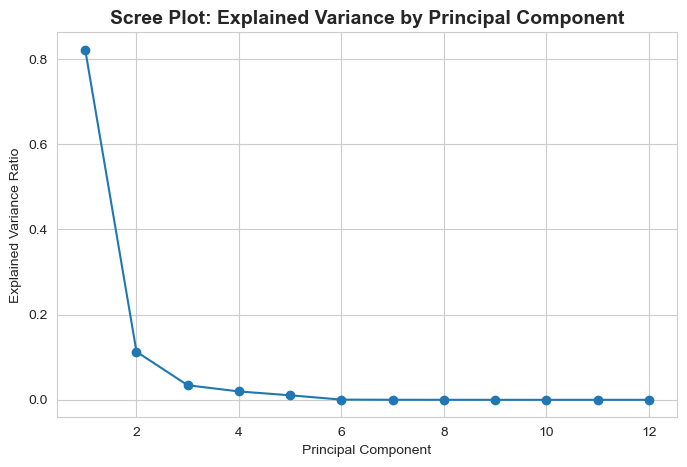

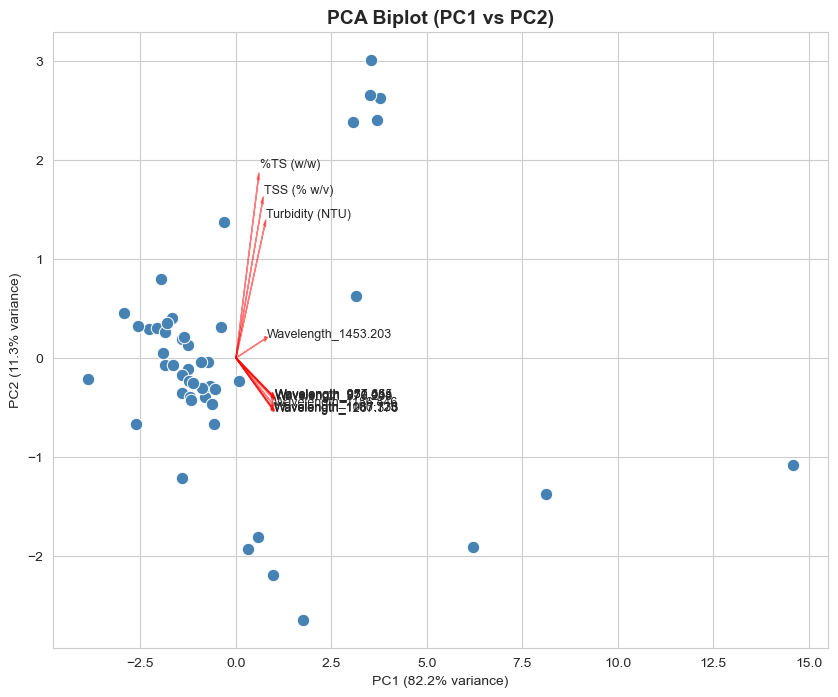

In [255]:
# --- Step 1: Keep only numeric columns ---
# Drop Sample_ID and any non-numeric columns like 'Type'
X = waves_physio.select_dtypes(include=[np.number])

# --- Step 2: Standardize data ---
X_scaled = StandardScaler().fit_transform(X)

# --- Step 3: Run PCA ---
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# --- Step 4: Scree plot ---
plt.figure(figsize=(8,5))
plt.plot(np.arange(1, len(pca.explained_variance_ratio_)+1),
         pca.explained_variance_ratio_, marker='o')
plt.title("Scree Plot: Explained Variance by Principal Component", fontsize=14, fontweight="bold")
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.grid(True)
plt.show()

# --- Step 5: Biplot (PC1 vs PC2) ---
plt.figure(figsize=(10,8))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], s=80, color="steelblue")
plt.title("PCA Biplot (PC1 vs PC2)", fontsize=14, fontweight="bold")
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)")

# Add loadings (variable contributions)
loadings = pca.components_.T[:, :2]
for i, feature in enumerate(X.columns):
    plt.arrow(0, 0, loadings[i,0]*3, loadings[i,1]*3, 
              color='red', alpha=0.5, head_width=0.05)
    plt.text(loadings[i,0]*3.2, loadings[i,1]*3.2, feature, fontsize=9)

plt.grid(True)
plt.show()

**PCA analysis with sample types replaced and color coded**

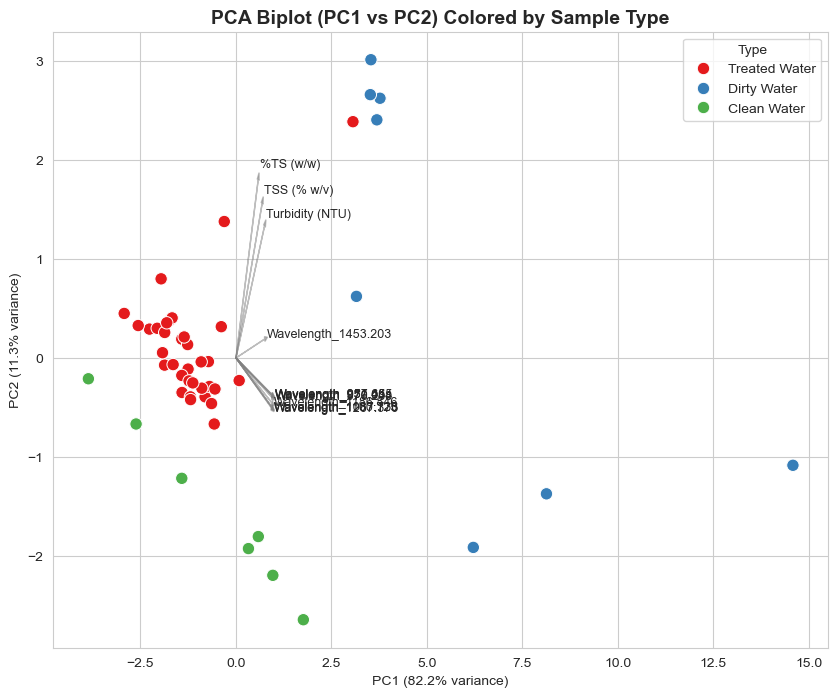

In [264]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# --- Step 1: Prepare numeric data for PCA ---
X = waves_physio.drop(columns=["Sample_ID","Type"])  # keep only numeric features
X_scaled = StandardScaler().fit_transform(X)

# --- Step 2: Run PCA ---
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# --- Step 3: Create DataFrame with PCA results + sample type ---
pca_df = pd.DataFrame({
    "PC1": X_pca[:,0],
    "PC2": X_pca[:,1],
    "Type": waves_physio["Type"].values
})

# --- Step 4: Plot biplot with color-coded sample types ---
plt.figure(figsize=(10,8))
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="Type", palette="Set1", s=80)

plt.title("PCA Biplot (PC1 vs PC2) Colored by Sample Type", fontsize=14, fontweight="bold")
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)")

# --- Step 5: Add loadings (variable contributions) ---
loadings = pca.components_.T[:, :2]
for i, feature in enumerate(X.columns):
    plt.arrow(0, 0, loadings[i,0]*3, loadings[i,1]*3, 
              color='gray', alpha=0.5, head_width=0.05)
    plt.text(loadings[i,0]*3.2, loadings[i,1]*3.2, feature, fontsize=9)

plt.grid(True)
plt.show()

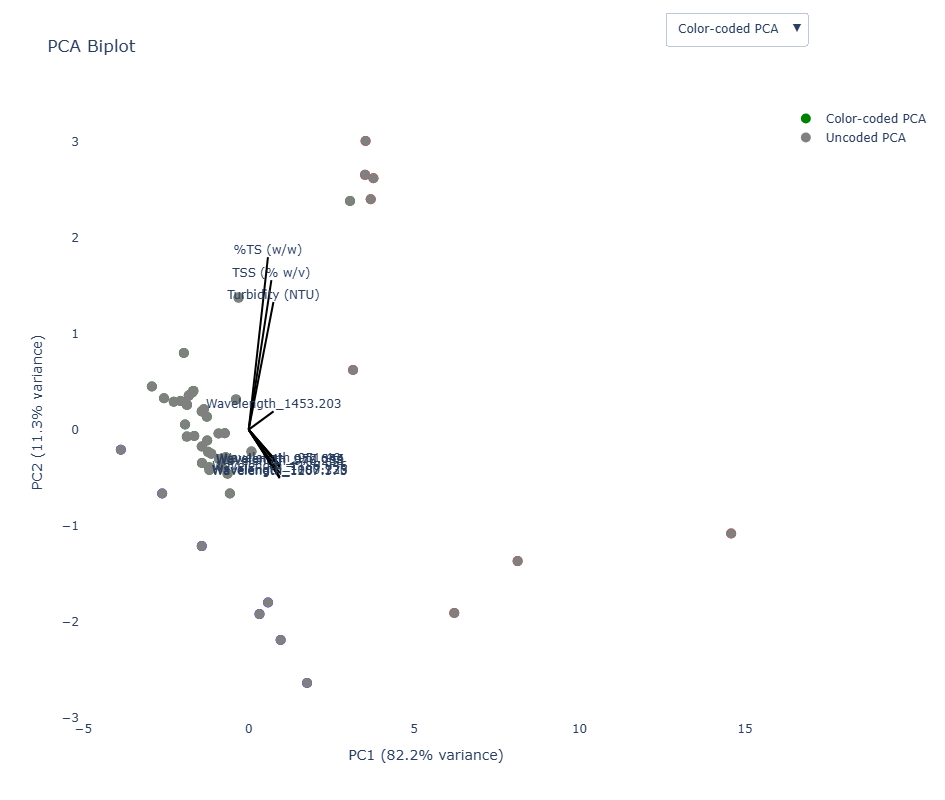

In [282]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import plotly.graph_objects as go

# --- Step 1: Prepare numeric data ---
X = waves_physio.drop(columns=["Sample_ID","Type"])  # numeric features only
X_scaled = StandardScaler().fit_transform(X)

# --- Step 2: Run PCA ---
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# --- Step 3: Create DataFrame with PCA results + sample type ---
pca_df = pd.DataFrame({
    "PC1": X_pca[:,0],
    "PC2": X_pca[:,1],
    "Type": waves_physio["Type"].values
})

# --- Step 4: Build figure with two traces (coded vs uncoded) ---
fig = go.Figure()

# Color-coded PCA
fig.add_trace(go.Scatter(
    x=pca_df["PC1"], y=pca_df["PC2"],
    mode="markers",
    marker=dict(size=10),
    text=pca_df["Type"],
    name="Color-coded PCA",
    marker_color=pca_df["Type"].map({"Clean Water":"blue","Dirty Water":"red","Treated Water":"green"})
))

# Uncoded PCA (all gray)
fig.add_trace(go.Scatter(
    x=pca_df["PC1"], y=pca_df["PC2"],
    mode="markers",
    marker=dict(size=10, color="gray"),
    text=pca_df["Type"],
    name="Uncoded PCA"
))

# --- Step 5: Add variance directional arrows (loadings) ---
loadings = pca.components_.T[:, :2]
for i, feature in enumerate(X.columns):
    fig.add_trace(go.Scatter(
        x=[0, loadings[i,0]*3],
        y=[0, loadings[i,1]*3],
        mode="lines+text",
        line=dict(color="black"),
        text=[None, feature],
        textposition="top center",
        showlegend=False
    ))

# --- Step 6: Add dropdown menu (top right) ---
fig.update_layout(
    updatemenus=[
        dict(
            buttons=list([
                dict(label="Color-coded PCA",
                     method="update",
                     args=[{"visible":[True, False] + [True]*len(X.columns)},
                           {"title":"PCA Biplot (Color-coded by Sample Type)"}]),
                dict(label="Uncoded PCA",
                     method="update",
                     args=[{"visible":[False, True] + [True]*len(X.columns)},
                           {"title":"PCA Biplot (Uncoded)"}])
            ]),
            direction="down",
            showactive=True,
            x=1.05, y=1.15,  # top right
            xanchor="right", yanchor="top"
        )
    ],
    title="PCA Biplot",
    xaxis_title=f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)",
    yaxis_title=f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)",
    height=800,
    plot_bgcolor="white",   # clean background
    paper_bgcolor="white"
)

fig.show()

**Linear Regression Workflow**

**Visualizing Fit**

In [256]:
# --- Step 1: Keep only numeric predictors (drop Sample_ID and Type) ---
X = waves_physio.drop(columns=["Sample_ID","Type","%TS (w/w)","TSS (% w/v)","Turbidity (NTU)"])
y_tss = waves_physio["TSS (% w/v)"]
y_turb = waves_physio["Turbidity (NTU)"]

# --- Step 2: Standardize predictors ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- Step 3: Fit regression models ---
model_tss = LinearRegression().fit(X_scaled, y_tss)
model_turb = LinearRegression().fit(X_scaled, y_turb)

# --- Step 4: Output regression functions ---
print("TSS model intercept:", model_tss.intercept_)
print("TSS model coefficients:", dict(zip(X.columns, model_tss.coef_)))

print("\nTurbidity model intercept:", model_turb.intercept_)
print("Turbidity model coefficients:", dict(zip(X.columns, model_turb.coef_)))

# --- Step 5: Evaluate performance ---
y_tss_pred = model_tss.predict(X_scaled)
y_turb_pred = model_turb.predict(X_scaled)

# Predictions from your fitted models
y_tss_pred = model_tss.predict(X_scaled)
y_turb_pred = model_turb.predict(X_scaled)

# Metrics
tss_r2 = r2_score(y_tss, y_tss_pred)
tss_mse = mean_squared_error(y_tss, y_tss_pred)
tss_rmse = np.sqrt(tss_mse)

turb_r2 = r2_score(y_turb, y_turb_pred)
turb_mse = mean_squared_error(y_turb, y_turb_pred)
turb_rmse = np.sqrt(turb_mse)

print(f"TSS R²:   {tss_r2:.3f}")
print(f"TSS RMSE: {tss_rmse:.3f}")

print(f"Turbidity R²:   {turb_r2:.3f}")
print(f"Turbidity RMSE: {turb_rmse:.3f}")



TSS model intercept: 0.0003576376948917685
TSS model coefficients: {'Wavelength_951.46': np.float64(0.0031983412299183196), 'Wavelength_957.655': np.float64(-0.0018576675663035853), 'Wavelength_970.044': np.float64(-0.003435648999490311), 'Wavelength_976.238': np.float64(0.010839420697873975), 'Wavelength_1087.736': np.float64(0.012367748977598089), 'Wavelength_1100.125': np.float64(-0.022551195070289024), 'Wavelength_1186.846': np.float64(0.002336179689992071), 'Wavelength_1267.373': np.float64(-0.0003694512723015229), 'Wavelength_1453.203': np.float64(-0.0001646755059979359)}

Turbidity model intercept: 334.30721205043005
Turbidity model coefficients: {'Wavelength_951.46': np.float64(6576.598545392243), 'Wavelength_957.655': np.float64(-18.49567211840132), 'Wavelength_970.044': np.float64(-6928.540376747501), 'Wavelength_976.238': np.float64(6438.280181535686), 'Wavelength_1087.736': np.float64(-2343.0917569501535), 'Wavelength_1100.125': np.float64(-4630.961008327776), 'Wavelength_1

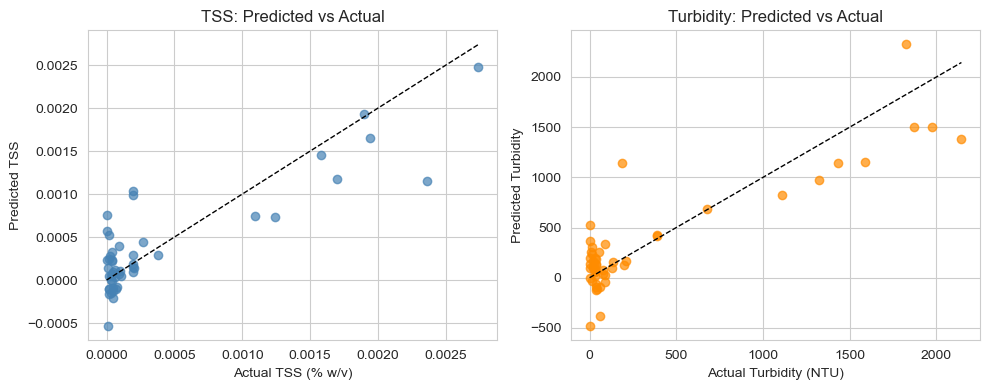

In [257]:
fig, axes = plt.subplots(1, 2, figsize=(10,4), sharex=False, sharey=False)

# TSS
axes[0].scatter(y_tss, y_tss_pred, color="steelblue", alpha=0.7)
axes[0].plot([y_tss.min(), y_tss.max()], [y_tss.min(), y_tss.max()], 'k--', lw=1)
axes[0].set_title("TSS: Predicted vs Actual")
axes[0].set_xlabel("Actual TSS (% w/v)")
axes[0].set_ylabel("Predicted TSS")

# Turbidity
axes[1].scatter(y_turb, y_turb_pred, color="darkorange", alpha=0.7)
axes[1].plot([y_turb.min(), y_turb.max()], [y_turb.min(), y_turb.max()], 'k--', lw=1)
axes[1].set_title("Turbidity: Predicted vs Actual")
axes[1].set_xlabel("Actual Turbidity (NTU)")
axes[1].set_ylabel("Predicted Turbidity")

plt.tight_layout()
plt.show()


**Linear Regression continued**

TSS (% w/v) = 0.000 + 0.003*Wavelength_951.46 + -0.002*Wavelength_957.655 + -0.003*Wavelength_970.044 + 0.011*Wavelength_976.238 + 0.012*Wavelength_1087.736 + -0.023*Wavelength_1100.125 + 0.002*Wavelength_1186.846 + -0.000*Wavelength_1267.373 + -0.000*Wavelength_1453.203
Turbidity (NTU) = 334.307 + 6576.599*Wavelength_951.46 + -18.496*Wavelength_957.655 + -6928.540*Wavelength_970.044 + 6438.280*Wavelength_976.238 + -2343.092*Wavelength_1087.736 + -4630.961*Wavelength_1100.125 + 3003.818*Wavelength_1186.846 + -1544.328*Wavelength_1267.373 + -188.602*Wavelength_1453.203

Coefficient Comparison Table:
            Wavelength  TSS_Coefficient  Turbidity_Coefficient     |TSS|  \
5  Wavelength_1100.125        -0.022551           -4630.961008  0.022551   
4  Wavelength_1087.736         0.012368           -2343.091757  0.012368   
3   Wavelength_976.238         0.010839            6438.280182  0.010839   
2   Wavelength_970.044        -0.003436           -6928.540377  0.003436   
0    Wavelengt

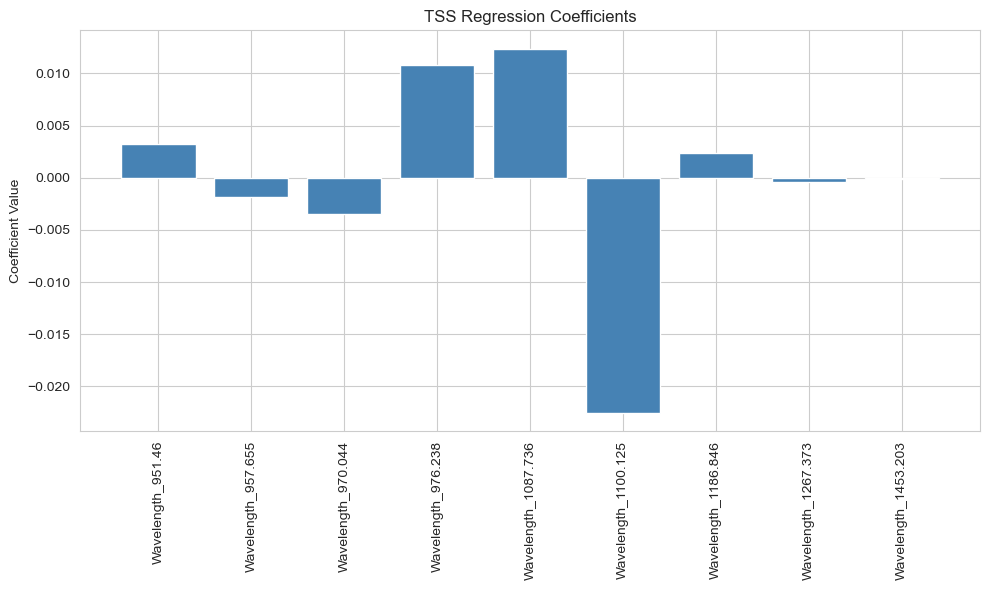

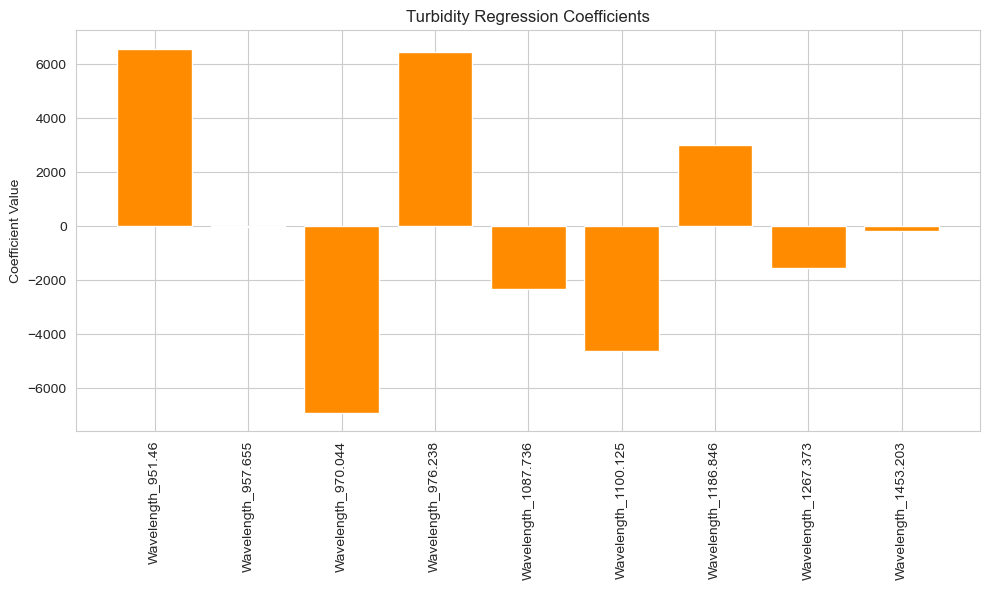

In [286]:
# --- Step 1: Prepare predictors and targets ---
X = waves_physio.drop(columns=["Sample_ID","Type","%TS (w/w)","TSS (% w/v)","Turbidity (NTU)"])
y_tss = waves_physio["TSS (% w/v)"]
y_turb = waves_physio["Turbidity (NTU)"]

# --- Step 2: Standardize predictors ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- Step 3: Fit regression models ---
model_tss = LinearRegression().fit(X_scaled, y_tss)
model_turb = LinearRegression().fit(X_scaled, y_turb)

# --- Step 4: Function to print equation ---
def print_equation(model, X, target_name):
    intercept = model.intercept_
    coefs = model.coef_
    terms = [f"{coef:.3f}*{feature}" for coef, feature in zip(coefs, X.columns)]
    equation = f"{target_name} = {intercept:.3f} + " + " + ".join(terms)
    print(equation)


# Print equations
print_equation(model_tss, X, "TSS (% w/v)")
print_equation(model_turb, X, "Turbidity (NTU)")

# --- Step 5: Build comparison DataFrame ---
coef_df = pd.DataFrame({
    "Wavelength": X.columns,
    "TSS_Coefficient": model_tss.coef_,
    "Turbidity_Coefficient": model_turb.coef_
})

# Add absolute values for easier ranking
coef_df["|TSS|"] = coef_df["TSS_Coefficient"].abs()
coef_df["|Turbidity|"] = coef_df["Turbidity_Coefficient"].abs()

# Sort by strongest contributors for clarity
coef_df_sorted = coef_df.sort_values(by="|TSS|", ascending=False)

print("\nCoefficient Comparison Table:")
print(coef_df_sorted)

# --- Step 5: Build comparison DataFrame ---
coef_df = pd.DataFrame({
    "Wavelength": X.columns,
    "TSS_Coefficient": model_tss.coef_,
    "Turbidity_Coefficient": model_turb.coef_
})

# --- Step 5: Plot TSS coefficients ---
plt.figure(figsize=(10,6))
plt.bar(coef_df["Wavelength"], coef_df["TSS_Coefficient"], color="steelblue")
plt.title("TSS Regression Coefficients")
plt.ylabel("Coefficient Value")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# --- Step 6: Plot Turbidity coefficients ---
plt.figure(figsize=(10,6))
plt.bar(coef_df["Wavelength"], coef_df["Turbidity_Coefficient"], color="darkorange")
plt.title("Turbidity Regression Coefficients")
plt.ylabel("Coefficient Value")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()
